<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                                   Pneumonia Detection
![Pneumonia](https://www.drugs.com/health-guide/images/022dc126-fc5d-4e54-9a78-75f2c9ea4bb6.jpg)
## Problem Interpretation:
   The goal is to build a pneumonia detection system, to locate the position of inflammation in an chest radiograph (CXR) image. With sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

## Data Interpretation:
  In the data, some of these are labeled **“Not Normal No Lung Opacity”**. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and often times this finding may mimic the appearance of true pneumonia.
 
## What files do I need?
  This is a two-stage challenge. You will need the images for the current stage - provided as **stage_2_train_images.zip** and **stage_2_test_images.zip**. You will also need the training data - **stage_2_train_labels.csv** - and the sample submission **stage_2_sample_submission.csv**, which provides the IDs for the test set, as well as a sample of what your submission should look like. The file **stage_2_detailed_class_info.csv** contains detailed information about the positive and negative classes in the training set, and may be used to build more nuanced models.

## What should I expect the data format to be?
  The training data is provided as a set of **patientIds** and bounding boxes. Bounding boxes are defined as follows: x-min y-min width height

There is also a binary target column, **Target**, indicating pneumonia or non-pneumonia.

There may be multiple rows per **patientId**.

## DICOM Images
  All provided images are in DICOM format. Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

## What am I predicting?
  Here we are predicting whether pneumonia exists in a given image. They do so by predicting bounding boxes around areas of the lung. Samples without bounding boxes are negative and contain no definitive evidence of pneumonia. Samples with bounding boxes indicate evidence of pneumonia.

When making predictions, competitors should predict as many bounding boxes as they feel are necessary, in the format: confidence x-min y-min width height

There should be only ONE predicted row per image. This row may include multiple bounding boxes.

A properly formatted row may look like any of the following.

For patientIds with no predicted pneumonia / bounding boxes: 0004cfab-14fd-4e49-80ba-63a80b6bddd6,

For patientIds with a single predicted bounding box: 0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.5 0 0 100 100

For patientIds with multiple predicted bounding boxes: 0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.5 0 0 100 100 0.5 0 0 100 100, etc.

## File descriptions
**stage_2_train.csv** - the training set. Contains patientIds and bounding box / target information.

**stage_2_sample_submission.csv** - a sample submission file in the correct format. Contains patientIds for the test set. Note that the sample submission contains one box per image, but there is no limit to the number of bounding boxes that can be assigned to a given image.

**stage_2_detailed_class_info.csv** - provides detailed information about the type of positive or negative class for each image.
## Data fields
patientId _- A patientId. Each patientId corresponds to a unique image.

x_ - the upper-left x coordinate of the bounding box.

y_ - the upper-left y coordinate of the bounding box.

width_ - the width of the bounding box.

height_ - the height of the bounding box.

Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.


## What is pneumonia?


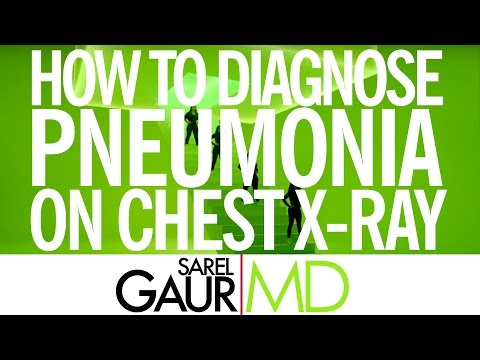

In [1]:

import IPython
IPython.display.YouTubeVideo('mMEen0O6xwc')

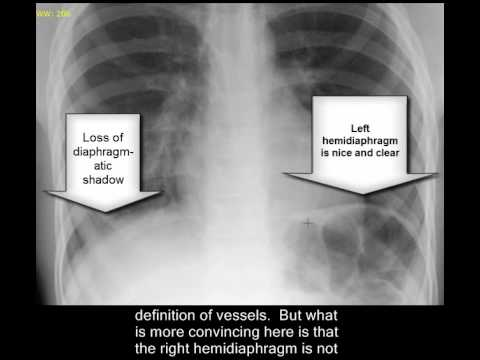

In [2]:
IPython.display.YouTubeVideo('o5czh4JM0Ho')

## Loading and Preparing the Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

In [5]:
!ls

'GCP Credits Request Link - RSNA.txt'   stage_2_test_images
 stage_2_detailed_class_info.csv        stage_2_train_images
 stage_2_sample_submission.csv	        stage_2_train_labels.csv


In [6]:
import pandas as pd
import numpy as np

In [7]:
pd_label = pd.read_csv('stage_2_train_labels.csv')
pd_class_info = pd.read_csv('stage_2_detailed_class_info.csv')

## EDA and Pre-Processing
  1. Lets review data in  train labels and details of each lebel, to see if there is any missing data
  2. Pre-Process missing data
  3. Although target has two label(0-> not pneumonia, 1->pneumonia), "not pneumonia" category has two category again. Normal & not normal. Need to check if "not pnemonia" category has any impact on final outcome

In [8]:
pd_label.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


It's clear that there are some patients which does not have any bounding box but there are target as Not Pneumonia.

In [9]:
pd_class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


First 4 patients does not  have any pneumonia but 3 patients does not have normal lungs(which is called here as No Lung Opacity).

In [10]:
pd_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [11]:
print("Total lablel patients entry:",pd_label.shape[0])
print("Unique label Patient:",pd_label.patientId.value_counts().shape[0])
print("Total patients entry:",pd_class_info.shape[0])
print('Unique class info patient:',pd_class_info.patientId.value_counts().shape[0])

Total lablel patients entry: 30227
Unique label Patient: 26684
Total patients entry: 30227
Unique class info patient: 26684


In [12]:
#Let concatenate to create a merged data set.
pd_pnm = pd.concat([pd_label,pd_class_info.drop('patientId',1)],1)

In [13]:
pd_pnm.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


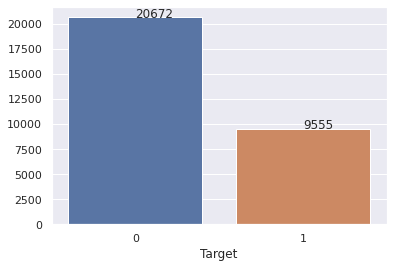

In [14]:
import seaborn as sns
sns.set(rc={'figure.figsize':(6,4)})

target = pd_pnm.groupby('Target').size()
g = sns.barplot(x=target.index, y=target.array)
x = 0.0
for val in target.array:
  g.text(x=x,y=val+2,s=val)
  x=x+1

In [15]:


classlabel = pd_pnm.groupby('class').size()


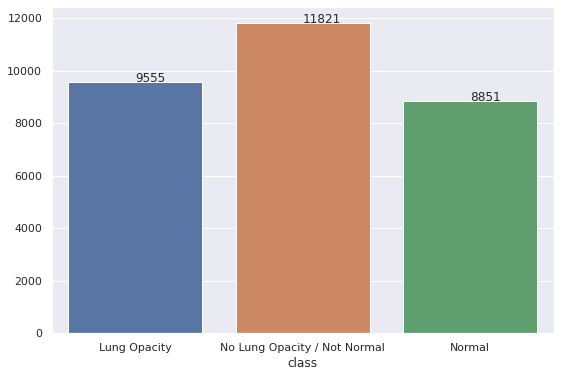

In [16]:
sns.set(rc={'figure.figsize':(9,6)})
g = sns.barplot(x=classlabel.index, y=classlabel.array)
x = 0.0
for val in classlabel.array:
  g.text(x=x,y=val+2,s=val)
  x=x+1

In [17]:
#Lets check how many bounding boxes for each patients 
#Even if bouding boxes is NaN, it is counted here.
bbox = pd_pnm.groupby("patientId").size().reset_index(name="BboxNo")
bbox.groupby('BboxNo').size().reset_index(name='Patient Count')

,BboxNo,Patient Count
0,1,23286
1,2,3266
2,3,119
3,4,13


                          class  Target  Patient_Count
0                  Lung Opacity       1           9555
1  No Lung Opacity / Not Normal       0          11821
2                        Normal       0           8851


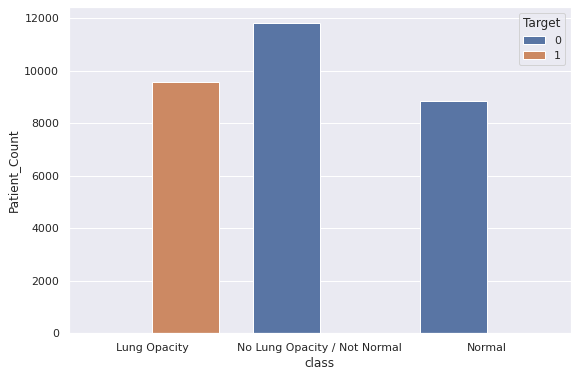

In [18]:
#Lets check how  each class(3) is distributed among each target(0,1))
class_target = pd_pnm.groupby(['class','Target']).size().reset_index(name='Patient_Count')
print(class_target.head())
# class_target['class']
sns.barplot(x="class",y ="Patient_Count",hue='Target',data=class_target)

### Study CXR image

  @TODO Describe how dicom files are stored

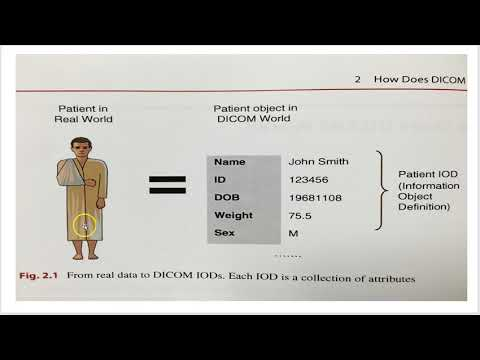

In [19]:
import IPython
IPython.display.YouTubeVideo('eCECXr-HxVs')

In [20]:
pip install pydicom

In [21]:
import pydicom
import matplotlib.pyplot as plt

In [22]:
# import glob
# train_dcms = glob.glob('stage_2_train_images/*.dcm')
# test_dcms = glob.glob('stage_2_test_images/*.dcm')

xray_train_folder = 'stage_2_train_images'
xray_test_folder = 'stage_2_test_images'
train_dcms = os.listdir(xray_train_folder)
test_dcms = os.listdir(xray_test_folder)
for i, f in enumerate(train_dcms):
  train_dcms[i] = xray_train_folder+'/'+f
for i, f in enumerate(test_dcms):
  test_dcms[i] = xray_test_folder+'/'+f

#Sometimes this timing out change it to 
#os.listdir(folder)

In [23]:
print("No of Train Image:{}, No pf Test Image:{}".format(len(train_dcms),len(test_dcms)))
train_dcms[0]

No of Train Image:26684, No pf Test Image:3000


'stage_2_train_images/f6ba1426-6cf9-42a8-ab35-ab0dcead78e2.dcm'

In [24]:
#lets print a sample image
dataset = pydicom.dcmread(train_dcms[0])
print(dataset)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.23189.1517874446.140912
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.23189.1517874446.140912
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [25]:

for d in dataset:
  pass
for t ,e in dataset.items():
  print("keyword=",e.keyword)

keyword= SpecificCharacterSet
keyword= SOPClassUID
keyword= SOPInstanceUID
keyword= StudyDate
keyword= StudyTime
keyword= AccessionNumber
keyword= Modality
keyword= ConversionType
keyword= ReferringPhysicianName
keyword= SeriesDescription
keyword= PatientName
keyword= PatientID
keyword= PatientBirthDate
keyword= PatientSex
keyword= PatientAge
keyword= BodyPartExamined
keyword= ViewPosition
keyword= StudyInstanceUID
keyword= SeriesInstanceUID
keyword= StudyID
keyword= SeriesNumber
keyword= InstanceNumber
keyword= PatientOrientation
keyword= SamplesPerPixel
keyword= PhotometricInterpretation
keyword= Rows
keyword= Columns
keyword= PixelSpacing
keyword= BitsAllocated
keyword= BitsStored
keyword= HighBit
keyword= PixelRepresentation
keyword= LossyImageCompression
keyword= LossyImageCompressionMethod
keyword= PixelData


In [26]:
# for timage in train_dcms:
timage = train_dcms[0]
patiendIDs = [os.path.basename(img).split('.')[0] for img in train_dcms]
len(patiendIDs) 

26684

In [27]:
#create a datafram of patientID & path. This will be merged with bounding box dataset
df_image = pd.DataFrame({"patientId":patiendIDs,"path":train_dcms})

In [28]:
df_image.sample(5)

,patientId,path
25401,0e2abdaa-d654-4824-abaa-9d6fe5b67a95,stage_2_train_images/0e2abdaa-d654-4824-abaa-9...
11373,9a3512ea-820e-481e-b0fb-2b4a53dfb43b,stage_2_train_images/9a3512ea-820e-481e-b0fb-2...
15013,743d1905-767a-4dc2-9082-b2f11df0ab39,stage_2_train_images/743d1905-767a-4dc2-9082-b...
13720,8bcd3888-211a-405d-8381-fa46bb068826,stage_2_train_images/8bcd3888-211a-405d-8381-f...
19537,55ea944b-984b-4f0d-a84d-e6b8b6660edc,stage_2_train_images/55ea944b-984b-4f0d-a84d-e...


In [29]:
#Merge merge bounding box dataset with image dataset
# first merge pd_pnm with bbox dataset
pd_bbox_pnm = pd.merge(pd_pnm,bbox,on='patientId')
df_final = pd.merge(pd_bbox_pnm,df_image,on='patientId',how='left')
print(df_final.shape[0])
df_final.head(6)

30227


,patientId,x,y,width,height,Target,class,BboxNo,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,1,stage_2_train_images/00322d4d-1c29-4943-afc9-b...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,1,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,2,stage_2_train_images/00436515-870c-4b36-a041-d...
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,2,stage_2_train_images/00436515-870c-4b36-a041-d...


In [30]:

def xray(filename):
  dataset = pydicom.dcmread(filename)
  
  # print(type(dataset))
  print()
  print("Filename.........:", filename)
  print("Storage type.....:", dataset.SOPClassUID)
  print()

  pat_name = dataset.PatientName
  display_name = pat_name.family_name + ", " + pat_name.given_name
  print("Patient's name...:", display_name)
  print("Patient id.......:", dataset.PatientID)
  print("Modality.........:", dataset.Modality)
  print("Study Date.......:", dataset.StudyDate)
  print("Study Date.......:", dataset.StudyDate)
  print("Patient Sex......:",dataset.PatientSex)
  print("Patient Age......:",dataset.PatientAge)
  print("Patient Body Part:",dataset.BodyPartExamined)
  print("Patient View Posi:",dataset.ViewPosition)
  if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

  
  print("Slice location...:", dataset.get('SliceLocation', "(missing)"))
  image = dataset.pixel_array
  print(type(image),image.dtype,image.shape)
  
  plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
  plt.show()

In [31]:
def showXray(row):
  rw = df_final.iloc[row]
  patID = rw.patientId
  dicomfile = rw.path
  title = rw['class']
  plt.title(title)
  xray(dicomfile)



Filename.........: stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, 
Patient id.......: 0004cfab-14fd-4e49-80ba-63a80b6bddd6
Modality.........: CR
Study Date.......: 19010101
Study Date.......: 19010101
Patient Sex......: F
Patient Age......: 51
Patient Body Part: CHEST
Patient View Posi: PA
Image size.......: 1024 x 1024, 142006 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]
Slice location...: (missing)
<class 'numpy.ndarray'> uint8 (1024, 1024)


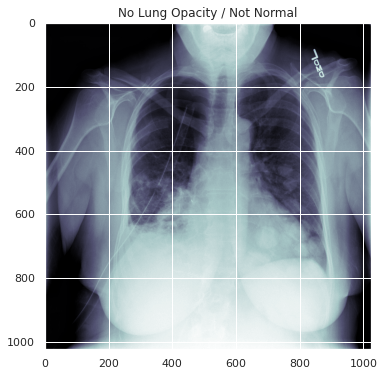

In [32]:
#Lets see xray for Not Normal but no Pneumonia case
showXray(0)


Filename.........: stage_2_train_images/003d8fa0-6bf1-40ed-b54c-ac657f8495c5.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5, 
Patient id.......: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5
Modality.........: CR
Study Date.......: 19010101
Study Date.......: 19010101
Patient Sex......: M
Patient Age......: 28
Patient Body Part: CHEST
Patient View Posi: PA
Image size.......: 1024 x 1024, 155284 bytes
Pixel spacing....: [0.14300000000000002, 0.14300000000000002]
Slice location...: (missing)
<class 'numpy.ndarray'> uint8 (1024, 1024)


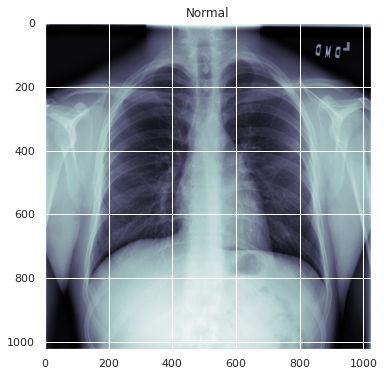

In [33]:
#Lets observe absolutely Normal & no Pneumonia case
showXray(3)


Filename.........: stage_2_train_images/00436515-870c-4b36-a041-de91049b9ab4.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 00436515-870c-4b36-a041-de91049b9ab4, 
Patient id.......: 00436515-870c-4b36-a041-de91049b9ab4
Modality.........: CR
Study Date.......: 19010101
Study Date.......: 19010101
Patient Sex......: F
Patient Age......: 32
Patient Body Part: CHEST
Patient View Posi: AP
Image size.......: 1024 x 1024, 119382 bytes
Pixel spacing....: [0.139, 0.139]
Slice location...: (missing)
<class 'numpy.ndarray'> uint8 (1024, 1024)


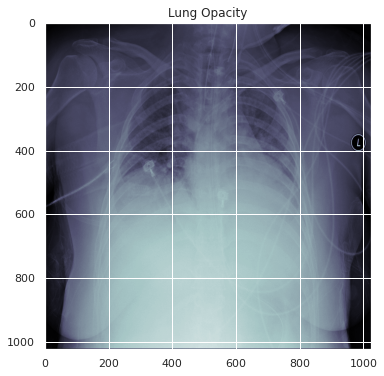

In [34]:
#Lets observe Lung Opacity & hence Pneumonia case
showXray(4)

@TODO Analysis of 3 classes visualization

@TODO add analysis of metadata, like age, sex, viewposition etc
 Show there is significant information we can get from the metadata regarding the target column

### Show the bounding box
All xray does not have bounding box.
There are maximum of 4 bounding box for a given x-ray

@TODO Dealing with missing bbox


In [35]:
df_pneumonia = df_final[df_final.Target == 1]
df_pneumonia.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9555 entries, 4 to 30226
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  9555 non-null   object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     9555 non-null   int64  
 6   class      9555 non-null   object 
 7   BboxNo     9555 non-null   int64  
 8   path       9555 non-null   object 
dtypes: float64(4), int64(2), object(3)
memory usage: 746.5+ KB


In [36]:
patients = set(df_pneumonia.patientId)
print("Unique patients :",len(patients))

Unique patients : 6012


In [37]:
def get_bbox_map(df_pn):
  bbox_map = {}
  for n, row in df_pn.iterrows():
    pid = row['patientId']
    if pid not in bbox_map:
      bbox_map[row.patientId] = {'path':row['path'], "bboxes":[] }
    bbox_map[pid]['bboxes'].append([int(float(row['y'])), int(float(row['x'])),
                                    int(float(row['height'])), int(float(row['width']))])
  return bbox_map

In [38]:
bbox_map = get_bbox_map(df_pneumonia)
print(bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'])
# bb = bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'].get('bboxes')
# print(bb)
# for i in bb:
#   for j in i:
#     print(type(j))

{'path': 'stage_2_train_images/000db696-cf54-4385-b10b-6b16fbb3f985.dcm', 'bboxes': [[318, 316, 478, 170], [375, 660, 402, 146]]}


In [39]:
bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'].get('bboxes')


[[318, 316, 478, 170], [375, 660, 402, 146]]

In [40]:
#get bbox_map for ceratain % as training time is very high
df_final_reduce = df_final.sample(frac=0.03,random_state=11)
bbox_map_reduce = get_bbox_map(df_final_reduce[df_final_reduce.Target == 1])

In [41]:
print(df_final_reduce.info())
print("No of pneomonia case:",len(bbox_map_reduce))
patient = np.array(df_final_reduce[df_final_reduce.Target == 1].sample().patientId)[0]
print('patient:',patient)
bb = bbox_map_reduce[patient].get('bboxes')
for i in bb:
  for j in i:
    print(type(j))
print(bb)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 907 entries, 25472 to 29548
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  907 non-null    object 
 1   x          307 non-null    float64
 2   y          307 non-null    float64
 3   width      307 non-null    float64
 4   height     307 non-null    float64
 5   Target     907 non-null    int64  
 6   class      907 non-null    object 
 7   BboxNo     907 non-null    int64  
 8   path       907 non-null    object 
dtypes: float64(4), int64(2), object(3)
memory usage: 70.9+ KB
None
No of pneomonia case: 304
patient: bcd2d62d-b9a4-4b2c-b8a8-ef27a1f65226
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
[[305, 584, 659, 294]]


In [42]:
def drawbbox(pid):
  dcm = pydicom.read_file(pid.get('path'))
  pixel = dcm.pixel_array
  pixel = np.stack([pixel] * 3, axis=2) #Convert into 3 channel
  for box in pid['bboxes']:
    box = [int(b) for b in box]
    y1, x1, height, width = box
    y2 = y1 + height
    x2 = x1 + width
    rgb = np.floor(np.random.rand(3) * 256).astype('int')
    # print(rgb)
    stroke = 6
    pixel[y1:y1 + stroke, x1:x2] = rgb
    pixel[y2:y2 + stroke, x1:x2] = rgb
    pixel[y1:y2, x1:x1 + stroke] = rgb
    pixel[y1:y2, x2:x2 + stroke] = rgb
  plt.imshow(pixel, cmap=plt.cm.gist_gray)
  plt.axis('off')

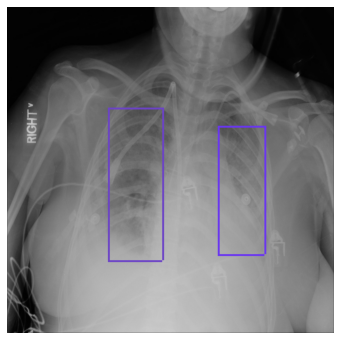

In [43]:
drawbbox(bbox_map['000db696-cf54-4385-b10b-6b16fbb3f985'])

In [44]:
set(df_pneumonia[df_pneumonia.BboxNo == 4].patientId)


{'0ab261f9-4eb5-42ab-a9a5-e918904d6356',
 '0d5bc737-03de-4bb8-98a1-45b7180c3e0f',
 '0e03c2d7-9cea-4dc7-8e91-794a8b3ff58d',
 '1bf08f3b-a273-4f51-bafa-b55ada2c23b5',
 '1c44e0a4-4612-438f-9a83-8d5bf919cb67',
 '31764d54-ea3b-434f-bae2-8c579ed13799',
 '3239951b-6211-4290-b237-3d9ad17176db',
 '32408669-c137-4e8d-bd62-fe8345b40e73',
 '349f10b4-dc3e-4f3f-b2e4-a5b81448ce87',
 '76f71a93-8105-4c79-a010-0cfa86f0061a',
 '7d674c82-5501-4730-92c5-d241fd6911e7',
 '8dc8e54b-5b05-4dac-80b9-fa48878621e2',
 'ee820aa5-4804-4984-97b3-f0a71d69702f'}

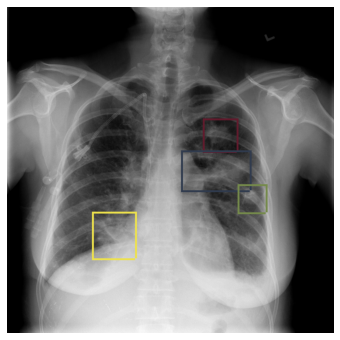

In [45]:
drawbbox(bbox_map['0ab261f9-4eb5-42ab-a9a5-e918904d6356'])

### Handling missing bounding box

In [46]:
#Check if there is any Target(non-pneumonia case) with bounding box
df_final[(np.isnan(df_final.x) == False) & (df_final.Target == 0)]

,patientId,x,y,width,height,Target,class,BboxNo,path


So there is no data having bounding box but it is not pneumonia case.

## Model Building


### Proposed Implementation Architeture
So to determine if the given xray has any pneumonia characteristics or opacity & locating the problamatic location in the xray, we can approach the problem in either of the below options.

Option 1:
  1. Given any xray build basic CNN model which can try to find any inherent pattern for target class(normal, not-normal, opage) without any bounding box. This is like **object recognition with classification**. This result is used along with metadata to find the target.
  2. Detection of bounding box using various **Object recognition with localization** algorithms if the image has any pneominia. Also use **Object detection** technique incase there is multiple location of pneumonia in given xray.
  

Option 2:

  Predicting target & bounding box directly using deep neural network(DNN) . For example **image segmentation** algorithm like "Mask R-CNN" to show pixels which belong to pneumonia opacity symtoms.
  

  
**Below is an high level architecture of proposed implementation of option 1.**

![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/General_flow_chart_proposed%20implementation.PNG)

As you can see there are 3 major module. Each of them gets executed sequentially.
1. **Pre-Processing module**: In this layer, metadat is extracted out from dicom file & if required black border also will be removed. Pre-Processed dicom image  (1024x1024) is passed to  both classification & detection module. Classificattin module also takes metadata extracted from dicom file + data (x,y,width,height) for final classification(if required).

2. **Classification module**: This module specialized exclusively in image classification. The output of the module shall consist of a single probability value between 0 and 1 of the presence or non-presence of pneumonia globally, i.e. as a function of the entire
image as a whole. In the first place, this module will allow us to globally categorize the sample in 2 classes: image with case of pneumonia and image free of any trace of pneumonia and secondly its output can directly influence the predictions obtained
in the detection module.
3. **Detection module**: This module specialized in the task of object detection. The result of this module will be a list of vectors where each one of them defines a bounding box detected. Each bounding box will be defined by 5 elements which are x1,y1, x2, y2 and confident score. The first 4 elements make up the coordinates that delimit the box detected and the last element, confidence score, defines the
probability that this box frames an area of pneumonia.





### Training and Prediction Strategies:
  1. Both classification & detection module will have mainly Convolution Neural Network(CNN). Classification stage final model will have Feed Forward Neural Network(FFNN).
  2. In the modules of classification and detection we are trying  to maximize the objective metric for which we have applied techniques of combination of multiple predictions for each model and more than one model in a weighted way.

  3. The dataset used is composed of DICOM format files and their corresponding annotations/meta data will be divided into 3 portions: **train, validation and test**. In the training process we will use only the training and validation portions. Test set will be reserved to evaluate the trained models and in the processes of combination of
predictions and models.

Below figure shows the workflow of the training process. In this process only the training
and validation subsets act. After each epoch the current model will be evaluated using
the validation set looking for optimal values of bias and variance. In both the training
and detection modules we will train multiple models.

  ![Proposed Architecture](https://raw.githubusercontent.com/pswaruppk/GL_CAPSTONE/master/data/Training_process.PNG)

### Metric for classification & detection module
We will be using the [*IOU & Precision Value*](https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/evaluation) metric for detection module & classification module.

### Basic CNN Segmentation(Option-2)
We will start with option 2. And we will start with simple CNN model training with dicom pixel array & try to understand the performance we are getting. This will be base refernce performance model. 
 We can then modify the layers and the activation functions to understand the effect they have on the performance. But, going by the typical computer vision solutions, it's highly unlikely that we will get excellent results from the shallow network. That's why, we will next shift to transfer learning using pre-trained models like VGG-16, VGG-19, UNET and then to even more advanced networks like Mask-RCNN and YOLOv3/4. But, in the interim report, we will focus primarily on training a shallow CNN model and using VGG models for transfer learning.



In [47]:
# Data generation
import gc
print("Unique patients:",len(bbox_map))
print("Unique reduce patients:",len(bbox_map_reduce))
print(pd.DataFrame(bbox_map).T.sample(5))
gc.collect()

Unique patients: 6012
Unique reduce patients: 304
                                                                                   path                                        bboxes
1693a790-88c8-46fa-9ce7-3b0c5834ba90  stage_2_train_images/1693a790-88c8-46fa-9ce7-3...                        [[273, 215, 150, 131]]
6f5d9135-ffc5-4076-872d-ba8a5bf7e8e4  stage_2_train_images/6f5d9135-ffc5-4076-872d-b...                        [[526, 217, 125, 176]]
f7446ce3-2bd4-48f1-a068-522b4f531c3f  stage_2_train_images/f7446ce3-2bd4-48f1-a068-5...  [[209, 327, 375, 221], [237, 687, 365, 200]]
71c67893-6acf-435b-b80d-9100ad2e5d2e  stage_2_train_images/71c67893-6acf-435b-b80d-9...  [[289, 607, 498, 176], [375, 133, 362, 217]]
b79d126e-d469-4dc1-82e8-b3167e6b52d3  stage_2_train_images/b79d126e-d469-4dc1-82e8-b...  [[417, 161, 230, 230], [487, 618, 170, 209]]


10832

In [48]:
#Partition on original image
# partition train images(train_dcms) into 3 categories. 1. training(70%), 2. Validation(15%) 3. test(15%)
def split_sample(dcms):
  np.random.shuffle(dcms)
  no_train_sample_index = int(len(dcms) *(0.7))
  no_valid_sample_index = int(len(dcms)* (0.85))
  train_filenames = dcms[:no_train_sample_index]
  valid_filenames = dcms[no_train_sample_index:no_valid_sample_index]
  test_filesnames = dcms[no_valid_sample_index:]
  print('training samples:', len(train_filenames))
  print('validation samples:', len(valid_filenames))
  print('test samples:',len(test_filesnames))
  print('Total dcm files:',len(dcms))
  print('Total partition length:',len(train_filenames)+len(valid_filenames)+len(test_filesnames))
  print("Train sample index:{} validation sample index:{}".format(no_train_sample_index,no_valid_sample_index))
  return train_filenames,valid_filenames,test_filesnames
print("Original:")
train_f,valid_f,test_f = split_sample(train_dcms)
print('Reduced:')
train_dcms_reduce = np.unique(df_final_reduce['path'])
train_f_red,valid_f_reduce,test_f_reduce = split_sample(train_dcms_reduce)

Original:
training samples: 18678
validation samples: 4003
test samples: 4003
Total dcm files: 26684
Total partition length: 26684
Train sample index:18678 validation sample index:22681
Reduced:
training samples: 632
validation samples: 136
test samples: 136
Total dcm files: 904
Total partition length: 904
Train sample index:632 validation sample index:768


#### Data generator

In [96]:
#AS the image set is huge, we can use input data generator on the fly using tensoflow sequence
import tensorflow as tf
from skimage.transform import resize
class generator(tf.keras.utils.Sequence):    
    def __init__(self, folder, filenames, pneumonia_locations=None, 
                 batch_size=32, image_size=256, 
                 shuffle=True, augment=False, predict=False,
                 verbose=False):
        self.v = verbose
        if (verbose) :print(("Constructor gets called"))
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
        
    def __load__(self, filename):
        # load dicom file as numpy array
        if (self.v): print(("Loading file:",filename))
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        file = filename.split('/')[1]
        patient = file.split('.')[0]
        # print("Patinet:",patient)
        # if image contains pneumonia
        if  patient in self.pneumonia_locations:
            # loop through pneumonia
            bboxes = self.pneumonia_locations[patient].get('bboxes')
            for bb in bboxes:
                # print("Masking boundary box")
                # add 1's at the location of the pneumonia
                # x, y, w, h = location
                if (self.v): print((bb))
                y, x, h, w = bb

                # print(type(y),type(x),type(h),type(w))
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and np.random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        # print("Loading done")
        return img, msk
    
    def __loadpredict__(self, filename):
        if self.v : print(("__loadpredict__ called")[v])
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        if (self.v): print(('__getitem__ called'))
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        # print(('on_epoch_end called'))
        if self.shuffle:
            np.random.shuffle(self.filenames)
        
    def __len__(self):
        # print(('__len__ called'))
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

#### Metric functions

In [97]:
from tensorflow.keras.layers import BatchNormalization,LeakyReLU,Conv2D,MaxPool2D,add,UpSampling2D
# Now lets define the evaulation metric function as given with the kaggle data set
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    #print(y_true)
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
   
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def create_downsample(channels, inputs):
    x = BatchNormalization(momentum=0.9)(inputs)
    x = LeakyReLU(0)(x)
    x = Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = BatchNormalization(momentum=0.9)(inputs)
    x = LeakyReLU(0)(x)
    x = Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0)(x)
    x = Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = tf.keras.Input(shape=(input_size, input_size, 1))
    x = Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = BatchNormalization(momentum=0.9)(x)
    x = LeakyReLU(0)(x)
    x = Conv2D(1, 1, activation='sigmoid')(x)
    outputs = UpSampling2D(2**depth)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [91]:
#Now lets define input  batch & image size. Defauling to smaller size for training time. 
#We will experiment with differant size along with original size 1024x1024
BATCH_SIZE = 128
IMAGE_SIZE = 128
# TRAIN_FILES = train_f_red
# BBOX_MAP = bbox_map_reduce
# VALID_FILES = valid_f_reduce
TRAIN_FILES = train_f
BBOX_MAP = bbox_map
VALID_FILES = valid_f

In [98]:
model = create_network(input_size=IMAGE_SIZE, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam', loss=iou_bce_loss, metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.0001
    epochs = 3
    return lr*(np.cos(np.pi*x/epochs)+1.)/2


learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = './'
train_gen = generator(folder, TRAIN_FILES, BBOX_MAP, batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False)
valid_gen = generator(folder, VALID_FILES, BBOX_MAP, batch_size=BATCH_SIZE, 
                      image_size=IMAGE_SIZE, shuffle=False, predict=False)

# print(model.summary())

In [99]:
# print('patient:',df_final_reduce[df_final_reduce.Target == 1].sample().patientId)
# bbox_map_reduce['400c2833-e303-4822-903a-621dd055712e']
# patient = np.array(df_final_reduce[df_final_reduce.Target == 1].sample().patientId)[0]
# dcm = BBOX_MAP[patient].get('path')
# dcm
# bb = BBOX_MAP[patient].get('bboxes')
# for i in bb:
#   for j in i:
#     print(type(j))

In [100]:
# train_gen.__load__(dcm)

#### Model fit

In [101]:
warnings.filterwarnings("ignore")
model_basic_cnn_file = 'model_basic_cnn.h5'

# if (os.isfile(model_basic_cnn_file)):
  EPOCHS=1
  start = time.clock()
  history = model.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=EPOCHS,verbose=1,
                    worker=5,use_multiprocessing=True)
  model.save(model_basic_cnn_file)
  end = time.clock()
  print('Time spent:', end-start)
# else:
#   model.load_weights(model_basic_cnn_file)
#Replace this with Model.fit with geneartor

Epoch 1/5
4/4 [==============================] - 120s 30s/step - loss: 0.8273 - accuracy: 0.5828 - mean_iou: 0.0255 - val_loss: 0.8351 - val_accuracy: 0.2917 - val_mean_iou: 0.0316
Epoch 2/5
4/4 [==============================] - 101s 25s/step - loss: 0.7786 - accuracy: 0.7253 - mean_iou: 0.0262 - val_loss: 0.8378 - val_accuracy: 0.4058 - val_mean_iou: 0.0272
Epoch 3/5
4/4 [==============================] - 117s 29s/step - loss: 0.7540 - accuracy: 0.8312 - mean_iou: 0.0182 - val_loss: 0.8278 - val_accuracy: 0.6577 - val_mean_iou: 0.0081
Epoch 4/5
4/4 [==============================] - 116s 29s/step - loss: 0.7467 - accuracy: 0.8538 - mean_iou: 0.0162 - val_loss: 0.8128 - val_accuracy: 0.7503 - val_mean_iou: 0.0035
Epoch 5/5
4/4 [==============================] - 117s 29s/step - loss: 0.7425 - accuracy: 0.8654 - mean_iou: 0.0166 - val_loss: 0.7917 - val_accuracy: 0.8063 - val_mean_iou: 0.0014


#### plot history

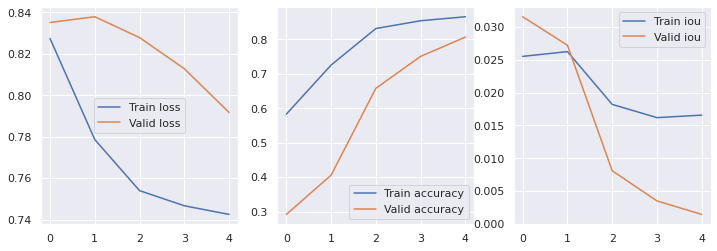

In [102]:
def plot_his(history):
  plt.figure(figsize=(12,4))
  plt.subplot(131)
  plt.plot(history.epoch, history.history["loss"], label="Train loss")
  plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
  plt.legend()
  plt.subplot(132)
  plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
  plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
  plt.legend()
  plt.subplot(133)
  plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
  plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
  plt.legend()
  plt.show()
plot_his(history)

In [120]:
from skimage import measure
import matplotlib.patches as patches

def disply_mask(gen,module):
  i=0
  for imgs, msks in gen:    
      # predict batch of images
      # plt.axis('off')
      preds = module.predict(imgs)
      # create figure
      f, axarr = plt.subplots(4, 8, figsize=(20,15))
      axarr = axarr.ravel()
      axidx = 0
      # loop through batch
      for img, msk, pred in zip(imgs, msks, preds):
          i=i+1
          #exit after 32 images
          if i>32:
              break
          # plot image
          axarr[axidx].imshow(img[:, :, 0])
          axarr[axidx].axis('off')
          # threshold true mask
          comp = msk[:, :, 0] > 0.5
          # apply connected components
          comp = measure.label(comp)
          # apply bounding boxes
          predictionString = ''
          for region in measure.regionprops(comp):
              # retrieve x, y, height and width
              y, x, y2, x2 = region.bbox
              height = y2 - y
              width = x2 - x
              axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,
                                                      edgecolor='b',facecolor='none'))
          # threshold predicted mask
          comp = pred[:, :, 0] > 0.6
          # apply connected components
          comp = measure.label(comp)
          # apply bounding boxes
          predictionString = ''
          for region in measure.regionprops(comp):
              # retrieve x, y, height and width
              y, x, y2, x2 = region.bbox
              height = y2 - y
              width = x2 - x
              axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,
                                                      edgecolor='r',facecolor='none'))
          axidx += 1
      plt.axis('off')
      plt.show()
      
      # only plot one batch
      break

#### plot mask

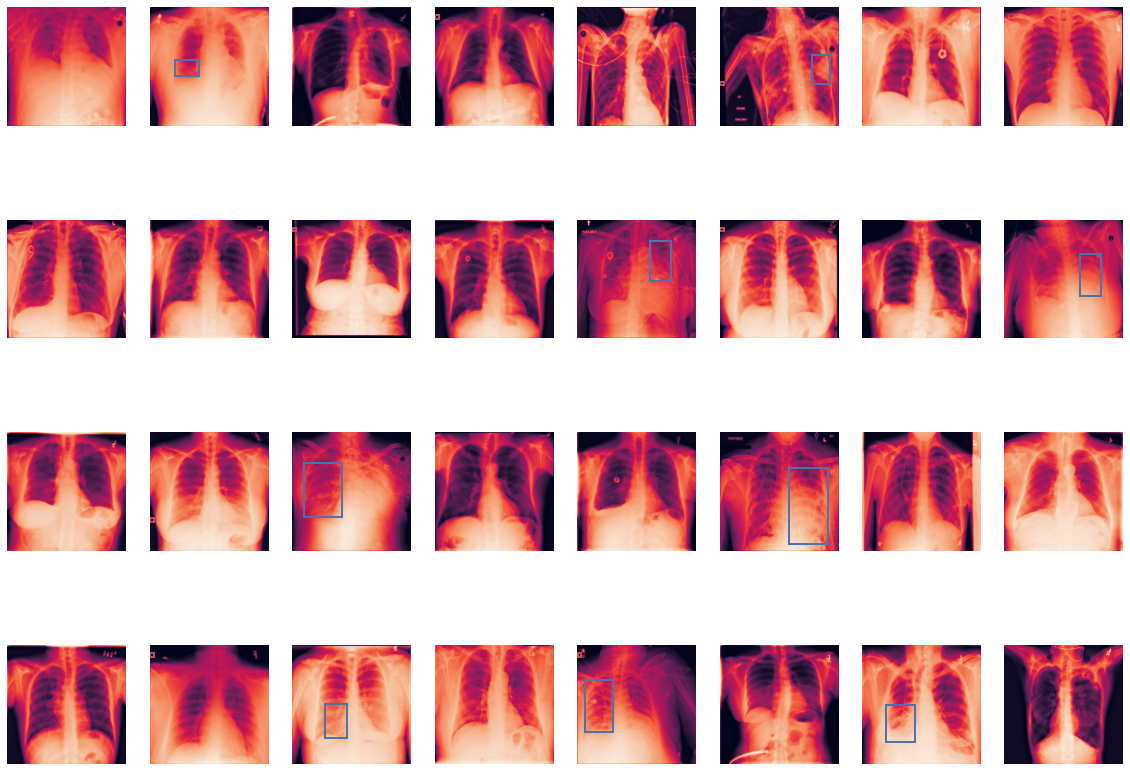

In [121]:
disply_mask(valid_gen,model)

#### Metric score

### Unet Segmentation(option2)
   Transfer learning

### VGG Net(option2)
   Transfer learning
  

## Milestone-1 Conclusion

## Milestone-2

### Hybrind model(option-1)


### Pre-Processing module

### Classification module

### Object detention module